In [2]:
#Load teh cameroon dataset 
import numpy as np
import os
from PIL import Image

import random
import tensorflow as tf

base_dir = "ChosenContext/Cameroon/preprocessing/Cameroon/dataset_split"


def normalize(x):
    x = x.astype("float32")

    # Remove NaN or infinity
    x = np.nan_to_num(x, nan=0.0, posinf=0.0, neginf=0.0)

    mn, mx = x.min(), x.max()
    if mx - mn < 1e-6:
        return np.zeros_like(x)    # flat tile = safe value

    x = (x - mn) / (mx - mn)
    return x


#load the 4 band images 
def load_images(folder):
    images = []
    fnames = sorted(os.listdir(folder))
    for f in fnames:
        if f.endswith(".npy"):
            arr = np.load(os.path.join(folder, f))  # shape = (512,512,4)
            images.append(normalize(arr))
    return images

# load the ground truth mask 
def load_masks(folder):
    masks = []
    fnames = sorted(os.listdir(folder))
    for f in fnames:
        if f.endswith(".png"):
            m = np.array(Image.open(os.path.join(folder, f)))
            m = (m > 127).astype("float32")       # convert to 0-1
            masks.append(m.reshape(512,512,1)) # shape = (512,512,1)
    return masks

# load train / val / test sets
train_images = load_images(base_dir + "train/images/")
train_masks  = load_masks(base_dir + "train/masks/")

val_images = load_images(base_dir + "val/images/")
val_masks  = load_masks(base_dir + "val/masks/")

test_images = load_images(base_dir + "test/images/")
test_masks  = load_masks(base_dir + "test/masks/")

print("Loaded:")
print("Train:", len(train_images), "images,", len(train_masks), "masks")
print("Val:", len(val_images), "images,", len(val_masks), "masks")
print("Test:", len(test_images), "images,", len(test_masks), "masks")

# Pre-process data, reshaping and transposing
# Convert lists to numpy arrays for training
train_x = np.stack(train_images)   
train_y = np.stack(train_masks)    

val_x = np.stack(val_images)
val_y = np.stack(val_masks)

test_x = np.stack(test_images)
test_y = np.stack(test_masks)

print("Train set shape:", train_x.shape, train_y.shape)
print("Val set shape:", val_x.shape, val_y.shape)
print("Test set shape:", test_x.shape, test_y.shape)

# Create TensorFlow datasets for training and validation sets
train_ds = tf.data.Dataset.from_tensor_slices((train_x, train_y)).batch(1)
val_ds   = tf.data.Dataset.from_tensor_slices((val_x, val_y)).batch(1)
test_ds  = tf.data.Dataset.from_tensor_slices((test_x, test_y)).batch(1)


class trainGenerator(tf.keras.utils.Sequence):
    def __init__(self, images, masks, batch_size=1, shuffle=True, augment=False):
        self.images = images        # use the already loaded arrays
        self.masks = masks          
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.augment = augment

        # convert masks to binary 0/1 float
        self.masks = (self.masks > 0.5).astype(np.float32)

        self.indexes = np.arange(len(self.images))
        self.on_epoch_end()

    def __len__(self):
        return len(self.indexes) // self.batch_size

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __getitem__(self, idx):
        batch_idx = self.indexes[idx*self.batch_size:(idx+1)*self.batch_size]

        batch_x = []
        batch_y = []

        for i in batch_idx:
            img = self.images[i].astype(np.float32)

            # ensure image is normalized 
            if img.max() > 1.0:
                img = img / 255.0

            mask = self.masks[i].astype(np.float32)

            if self.augment:
                img, mask = self.apply_augment(img, mask)

            # expand mask channel if needed
            if len(mask.shape) == 2:
                mask = mask[..., None]

            batch_x.append(img)
            batch_y.append(mask)

        return np.array(batch_x), np.array(batch_y)

    def apply_augment(self, img, mask):
        # Horizontal flip
        if random.random() < 0.5:
            img = np.flip(img, 1)
            mask = np.flip(mask, 1)

        # Vertical flip
        if random.random() < 0.5:
            img = np.flip(img, 0)
            mask = np.flip(mask, 0)

        return img, mask
#
# Produce generators for training images
#
# Stack lists into arrays
t_images = train_x
t_masks  = train_y
v_images = val_x
v_masks  = val_y


train_gen = trainGenerator(
    images=train_x,
    masks=train_y,
    batch_size=1,
    shuffle=True,
    augment=True
)

val_gen = trainGenerator(
    images=val_x,
    masks=val_y,
    batch_size=1,
    shuffle=False,
    augment=False #no augmentation in validation 
)

val_images_list = val_x   
val_masks_list  = val_y   


print("val_images_list:", val_images_list.shape)
print("val_masks_list:", val_masks_list.shape)


Loaded:
Train: 41 images, 41 masks
Val: 23 images, 23 masks
Test: 5 images, 5 masks
Train set shape: (41, 512, 512, 4) (41, 512, 512, 1)
Val set shape: (23, 512, 512, 4) (23, 512, 512, 1)
Test set shape: (5, 512, 512, 4) (5, 512, 512, 1)
val_images_list: (23, 512, 512, 4)
val_masks_list: (23, 512, 512, 1)


Baseline model input shape: (1, 512, 512, 4)
New model input shape:      (None, 512, 512, 4)
Validation size: 23
Predicting baseline model (one-by-one)...
Predicting new model (one-by-one)...
Baseline preds shape: (23, 512, 512, 1)
New preds shape:      (23, 512, 512, 1)

===== PAIRED T-TESTS (new_model vs baseline_model) =====

Metric: ACCURACY
  baseline mean = 0.8776  std=0.0935
  new mean      = 0.9585  std=0.0286
  paired t p-value = 6.7759e-05
  => Statistically significant difference (p < 0.05)

Metric: PRECISION
  baseline mean = 0.9831  std=0.0353
  new mean      = 0.9717  std=0.0333
  paired t p-value = 2.2563e-01
  => No significant difference (p >= 0.05)

Metric: RECALL
  baseline mean = 0.8590  std=0.1076
  new mean      = 0.9763  std=0.0260
  paired t p-value = 2.0438e-06
  => Statistically significant difference (p < 0.05)

Metric: F1
  baseline mean = 0.9139  std=0.0742
  new mean      = 0.9735  std=0.0206
  paired t p-value = 1.5511e-04
  => Statistically significant d

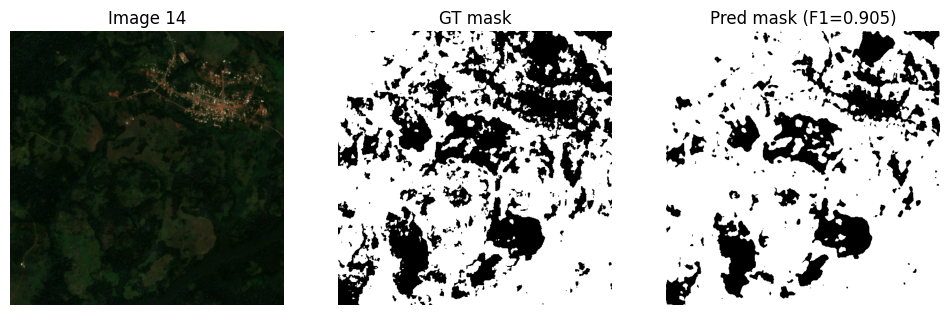

Index: 2 F1: 0.9365426695839879


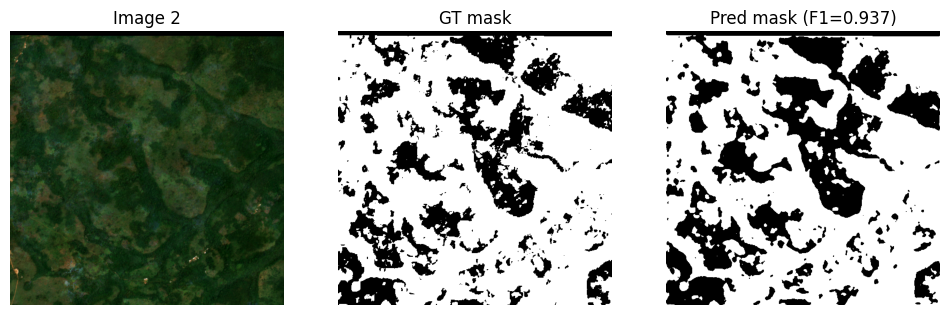

Index: 3 F1: 0.9494076928840564


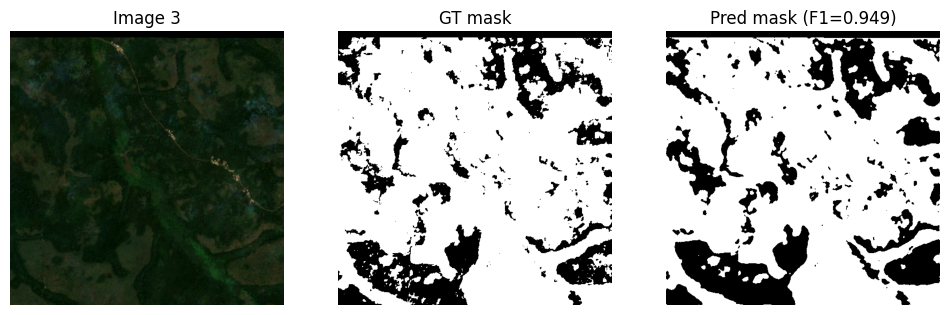

Index: 11 F1: 0.9566935435200483


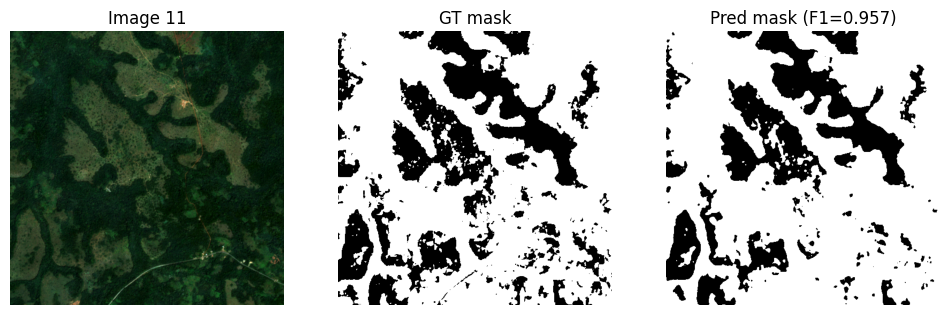

Index: 1 F1: 0.9588673000304115


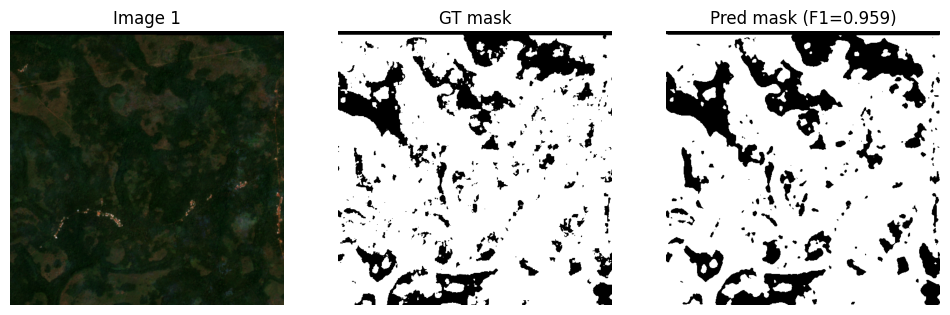

Saved per-image metrics to model_comparison_per_image_metrics.csv


In [4]:
import os
import numpy as np
import tensorflow as tf
from scipy.stats import ttest_rel
import matplotlib.pyplot as plt


baseline_path = "ReplicateBaseline/unet-attention-4d.hdf5"
new_path      = "ChosenContext/Cameroon/preprocessing/unet_attention_cameroon_best.keras"


val_images = val_x   
val_masks  = val_y   


# Load models 
baseline_model = tf.keras.models.load_model(baseline_path, compile=False)
new_model      = tf.keras.models.load_model(new_path, compile=False, safe_mode=False)

print("Baseline model input shape:", baseline_model.input_shape)
print("New model input shape:     ", new_model.input_shape)
N = len(val_images)
print("Validation size:", N)

# metric function
def compute_metrics_single(pred, true, threshold=0.5):
    
    if pred.ndim == 2:
        pred = pred[..., None]
    if true.ndim == 2:
        true = true[..., None]

    pred_bin = (pred > threshold).astype(np.int32)
    true_bin = (true > 0.5).astype(np.int32)

    tp = np.sum((pred_bin == 1) & (true_bin == 1))
    tn = np.sum((pred_bin == 0) & (true_bin == 0))
    fp = np.sum((pred_bin == 1) & (true_bin == 0))
    fn = np.sum((pred_bin == 0) & (true_bin == 1))

    accuracy = (tp + tn) / (tp + tn + fp + fn + 1e-7)
    precision = tp / (tp + fp + 1e-7)
    recall = tp / (tp + fn + 1e-7)
    f1 = (2 * tp) / (2 * tp + fp + fn + 1e-7)
    iou = tp / (tp + fp + fn + 1e-7)

    return accuracy, precision, recall, f1, iou

#  Predict one-by-one 
def predict_per_image(model, images):
    preds = []
    for i in range(len(images)):
        x = images[i].astype(np.float32)
        # expand batch dimension
        x_b = np.expand_dims(x, axis=0)  # shape (1,H,W,C)
        p = model.predict(x_b, verbose=0)[0]  # shape (H,W,1) or (H,W)
        # ensure correct shape (H,W,1)
        if p.ndim == 2:
            p = p[..., None]
        preds.append(p)
    return np.stack(preds, axis=0)  # (N,H,W,1)

print("Predicting baseline model (one-by-one)...")
baseline_preds = predict_per_image(baseline_model, val_images)
print("Predicting new model (one-by-one)...")
new_preds = predict_per_image(new_model, val_images)

print("Baseline preds shape:", baseline_preds.shape)
print("New preds shape:     ", new_preds.shape)

# Compute per-image metrics 
metrics = ["accuracy", "precision", "recall", "f1", "iou"]
baseline_scores = {m: [] for m in metrics}
new_scores      = {m: [] for m in metrics}

for i in range(N):
    b = compute_metrics_single(baseline_preds[i], val_masks[i])
    n = compute_metrics_single(new_preds[i],      val_masks[i])
    for k, m in enumerate(metrics):
        baseline_scores[m].append(b[k])
        new_scores[m].append(n[k])

#  Paired t-tests 
print("\n===== PAIRED T-TESTS (new_model vs baseline_model) =====")
alpha = 0.05
for m in metrics:
    b_arr = np.array(baseline_scores[m])
    n_arr = np.array(new_scores[m])
    # paired t-test 
    t_stat, p_val = ttest_rel(n_arr, b_arr)
    print(f"\nMetric: {m.upper()}")
    print(f"  baseline mean = {b_arr.mean():.4f}  std={b_arr.std():.4f}")
    print(f"  new mean      = {n_arr.mean():.4f}  std={n_arr.std():.4f}")
    print(f"  paired t p-value = {p_val:.4e}")
    if p_val < alpha:
        print("  => Statistically significant difference (p < {:.2g})".format(alpha))
    else:
        print("  => No significant difference (p >= {:.2g})".format(alpha))

# Error analysis: worst cases based on F1 score for the new model 
f1_new = np.array(new_scores["f1"])
worst_idx = np.argsort(f1_new)[:5]  # 5 worst

def show_case(idx):
    img = val_images[idx]
    gt  = val_masks[idx].squeeze()
    pred = new_preds[idx].squeeze()  
    plt.figure(figsize=(12,4))
    plt.subplot(1,3,1); plt.imshow(normalize_for_display(img[:,:,:3] if img.shape[2] >= 3 else img[:,:,0]), cmap=None); plt.title(f"Image {idx}"); plt.axis('off')
    plt.subplot(1,3,2); plt.imshow(gt, cmap='gray'); plt.title("GT mask"); plt.axis('off')
    plt.subplot(1,3,3); plt.imshow(pred > 0.5, cmap='gray'); plt.title(f"Pred mask (F1={f1_new[idx]:.3f})"); plt.axis('off')
    plt.show()

# RGB display (normalize each band to 0-1)
def normalize_for_display(img):
    img = img.astype(np.float32)
    if img.ndim == 2:
        return img
    out = np.zeros_like(img)
    for b in range(img.shape[2]):
        band = img[:,:,b]
        mn, mx = band.min(), band.max()
        if mx - mn > 1e-6:
            out[:,:,b] = (band - mn)/(mx-mn)
    # if more than 3 channels,only take first 3
    if out.shape[2] > 3:
        return out[:,:,:3]
    return out

print("\n===== WORST 5 CASES FOR NEW MODEL (by F1) =====")
for idx in worst_idx:
    print("Index:", idx, "F1:", f1_new[idx])
    show_case(idx)

#  save per-image metrics to CSV
import pandas as pd
df = pd.DataFrame({
    "idx": np.arange(N),
    **{f"baseline_{m}": baseline_scores[m] for m in metrics},
    **{f"new_{m}": new_scores[m] for m in metrics},
})
csv_path = "model_comparison_per_image_metrics.csv"
df.to_csv(csv_path, index=False)
print("Saved per-image metrics to", csv_path)


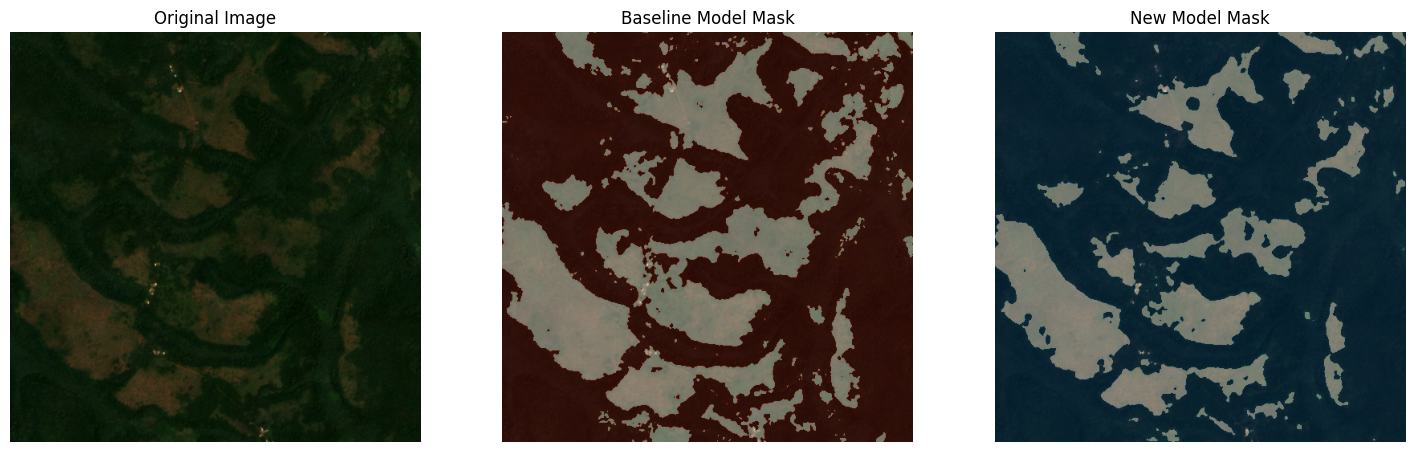

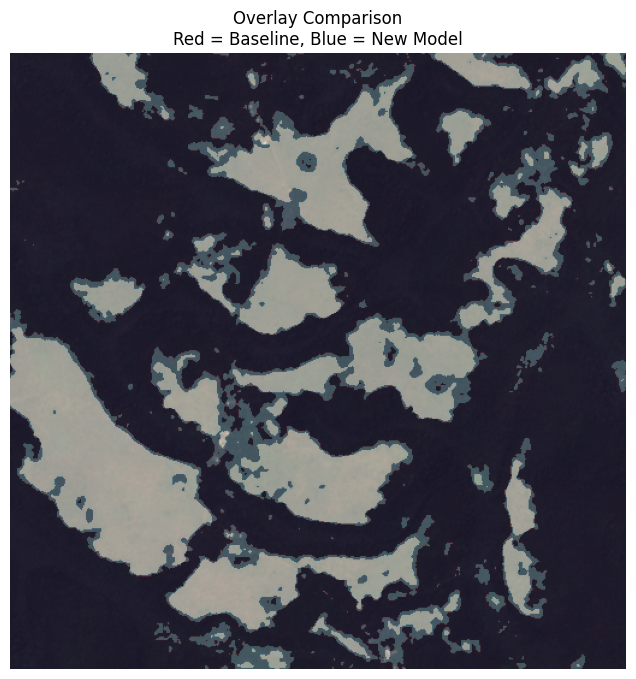

In [14]:
import numpy as np
import matplotlib.pyplot as plt


idx =4  # a image from the validation set 

img  = val_x[idx]         
mask_true = val_y[idx]    
mask_base = baseline_preds[idx]  
mask_new  = new_preds[idx]       

# make 4-band images vissible 
rgb = img[..., :3]
rgb = (rgb - rgb.min()) / (rgb.max() - rgb.min())  # normalize for display

#make sure mask are 2d
mask_true = mask_true.squeeze()
mask_base = (mask_base.squeeze() > 0.5).astype(int)
mask_new  = (mask_new.squeeze() > 0.5).astype(int)


plt.figure(figsize=(18, 8))

#shows a side by side comparison of the mask 

plt.subplot(1, 3, 1)
plt.title("Original Image")
plt.imshow(rgb)
plt.axis("off")

plt.subplot(1, 3, 2)
plt.title("Baseline Model Mask")
plt.imshow(rgb)
plt.imshow(mask_base, cmap="Reds", alpha=0.4)
plt.axis("off")

plt.subplot(1, 3, 3)
plt.title("New Model Mask")
plt.imshow(rgb)
plt.imshow(mask_new, cmap="Blues", alpha=0.4)
plt.axis("off")

plt.show()


#overlaps the images to see direct comparisson 
plt.figure(figsize=(8, 8))
plt.title("Overlay Comparison\nRed = Baseline, Blue = New Model")

plt.imshow(rgb)
plt.imshow(mask_base, cmap="Reds", alpha=0.35)
plt.imshow(mask_new,  cmap="Blues", alpha=0.35)

plt.axis("off")
plt.show()
